In [ ]:
#installing required libraries
!pip install catboost
!pip install lightgbm
!pip install shap


In [1]:
#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing libraries for model building and model processing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import catboost as cb
import shap
from sklearn.ensemble import StackingRegressor


#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'catboost'

In [ ]:
#deriving the function to find the adjusted r squared
def adjusted_r2_score(y_true, y_pred, n_features):
    # Calculate the R-squared score
    r2 = r2_score(y_true, y_pred)

    # Number of samples
    n_samples = len(y_true)

    # Calculate the adjusted R-squared score
    adj_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))

    return adj_r2

In [ ]:
#Customizing the settings
pd.options.display.max_columns = None  #setting max viewable columns
pd.options.display.float_format = '{:.2f}'.format  #setting the view in float instead of exponent format

In [ ]:
#Reading the raw house data set csv
#download link for innerCity csv file https://drive.google.com/file/d/1d3Az8SywHcMAg--nmynVgUwuTP1wVKAi/view?usp=sharing
raw_data = pd.read_csv('innerCity.csv')

#priting the raw_data
raw_data.head()

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.00,1.75,3050.00,9440.00,1,0,0.00,3,8.00,1800.00,1250.00,1966,0,98034,47.72,-122.183,2020.00,8660.00,0.00,12490
1,3145600250,20150317T000000,190000,2.00,1.00,670.00,3101.00,1,0,0.00,4,6.00,670.00,0.00,1948,0,98118,47.55,-122.274,1660.00,4100.00,0.00,3771
2,7129303070,20140820T000000,735000,4.00,2.75,3040.00,2415.00,2,1,4.00,3,8.00,3040.00,0.00,1966,0,98118,47.52,-122.256,2620.00,2433.00,0.00,5455
3,7338220280,20141010T000000,257000,3.00,2.50,1740.00,3721.00,2,0,0.00,3,8.00,1740.00,0.00,2009,0,98002,47.34,-122.213,2030.00,3794.00,0.00,5461
4,7950300670,20150218T000000,450000,2.00,1.00,1120.00,4590.00,1,0,0.00,3,7.00,1120.00,0.00,1924,0,98118,47.57,-122.285,1120.00,5100.00,0.00,5710


In [ ]:
#reading zip_codes csv where we will take city names from
#download link for zip_codes_ml csv file https://drive.google.com/file/d/1-cTlP3u_iiYK945kALQw7uBLr28HXJc5/view?usp=sharing
zip_codes = pd.read_csv('zip_codes_ml.csv')

#printing the zip_codes data frame
zip_codes

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,98001,STANDARD,0,Auburn,"Algona, Federal Way",NaN,WA,King County,America/Los_Angeles,253,NaN,US,47.30,-122.26,34130
1,98002,STANDARD,0,Auburn,NaN,NaN,WA,King County,America/Los_Angeles,253,NaN,US,47.31,-122.22,32620
2,98003,STANDARD,0,Federal Way,Auburn,NaN,WA,King County,America/Los_Angeles,253,NaN,US,47.30,-122.31,43270
3,98004,STANDARD,0,Bellevue,"Beaux Arts, Clyde Hill, Hunts Point, Yarrow Point",Beaux Arts Village,WA,King County,America/Los_Angeles,"206, 425",NaN,US,47.61,-122.21,33600
4,98005,STANDARD,0,Bellevue,NaN,NaN,WA,King County,America/Los_Angeles,425,NaN,US,47.62,-122.16,18660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,98191,UNIQUE,0,Seattle,NaN,Qwest,WA,King County,America/Los_Angeles,206,NaN,US,47.61,-122.33,0
133,98194,PO BOX,0,Seattle,NaN,NaN,WA,King County,America/Los_Angeles,206,NaN,US,47.61,-122.33,299
134,98195,UNIQUE,0,Seattle,NaN,Univ Of Washington,WA,King County,America/Los_Angeles,206,NaN,US,47.65,-122.31,192
135,98198,STANDARD,0,Seattle,"Des Moines, Normandy Park, Seatac",Redondo Beach,WA,King County,America/Los_Angeles,"206, 253",NaN,US,47.38,-122.31,34200


# **1. Data cleaning and preprocessing**

### **Data inspection**


In [ ]:
#Inspecting the columns of the data set
raw_data.columns

Index(['cid', 'dayhours', 'price', 'room_bed', 'room_bath', 'living_measure',
       'lot_measure', 'ceil', 'coast', 'sight', 'condition', 'quality',
       'ceil_measure', 'basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'living_measure15', 'lot_measure15', 'furnished',
       'total_area'],
      dtype='object')

In [ ]:
#Inspecting the data types of all the columns of the data set
raw_data.dtypes

cid                   int64
dayhours             object
price                 int64
room_bed            float64
room_bath           float64
living_measure      float64
lot_measure         float64
ceil                 object
coast                object
sight               float64
condition            object
quality             float64
ceil_measure        float64
basement            float64
yr_built             object
yr_renovated          int64
zipcode               int64
lat                 float64
long                 object
living_measure15    float64
lot_measure15       float64
furnished           float64
total_area           object
dtype: object

In [ ]:
#Inspecting the shape of raw data
raw_data.shape

(21613, 23)

In [ ]:
#Getting the meta information of the housing data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               21613 non-null  int64  
 1   dayhours          21613 non-null  object 
 2   price             21613 non-null  int64  
 3   room_bed          21505 non-null  float64
 4   room_bath         21505 non-null  float64
 5   living_measure    21596 non-null  float64
 6   lot_measure       21571 non-null  float64
 7   ceil              21571 non-null  object 
 8   coast             21612 non-null  object 
 9   sight             21556 non-null  float64
 10  condition         21556 non-null  object 
 11  quality           21612 non-null  float64
 12  ceil_measure      21612 non-null  float64
 13  basement          21612 non-null  float64
 14  yr_built          21612 non-null  object 
 15  yr_renovated      21613 non-null  int64  
 16  zipcode           21613 non-null  int64 

In [ ]:
#Printing the statistical inference for the data set
raw_data.describe()

,cid,price,room_bed,room_bath,living_measure,lot_measure,sight,quality,ceil_measure,basement,yr_renovated,zipcode,lat,living_measure15,lot_measure15,furnished
count,21613.00,21613.00,21505.00,21505.00,21596.00,21571.00,21556.00,21612.00,21612.00,21612.00,21613.00,21613.00,21613.00,21447.00,21584.00,21584.00
mean,4580301520.86,540182.16,3.37,2.12,2079.86,15104.58,0.23,7.66,1788.37,291.52,84.40,98077.94,47.56,1987.07,12766.54,0.20
std,2876565571.31,367362.23,0.93,0.77,918.50,41423.62,0.77,1.18,828.10,442.58,401.68,53.51,0.14,685.52,27286.99,0.40
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,0.00,1.00,290.00,0.00,0.00,98001.00,47.16,399.00,651.00,0.00
25%,2123049194.00,321950.00,3.00,1.75,1429.25,5040.00,0.00,7.00,1190.00,0.00,0.00,98033.00,47.47,1490.00,5100.00,0.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,0.00,7.00,1560.00,0.00,0.00,98065.00,47.57,1840.00,7620.00,0.00
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10684.50,0.00,8.00,2210.00,560.00,0.00,98118.00,47.68,2360.00,10087.00,0.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,4.00,13.00,9410.00,4820.00,2015.00,98199.00,47.78,6210.00,871200.00,1.00


In [ ]:
#Counting the null values in each column
raw_data.isna().sum()

cid                   0
dayhours              0
price                 0
room_bed            108
room_bath           108
living_measure       17
lot_measure          42
ceil                 42
coast                 1
sight                57
condition            57
quality               1
ceil_measure          1
basement              1
yr_built              1
yr_renovated          0
zipcode               0
lat                   0
long                  0
living_measure15    166
lot_measure15        29
furnished            29
total_area           29
dtype: int64

## Removing unwanted variables


In [ ]:
#Removing unwanted features in our dataset
#1.  cid column is removed and the reason being it has nothing to do with the model
#2.  yr_renoveted column is being removed as it has over 20000 entries with 0 and has opposed relation with living and lot measure 2015
#3.   lat and long columns are being removed as we are considering the pincode for geographical computation
processing_data = raw_data.drop(['cid', 'yr_renovated', 'lat', 'long'], axis=1)


In [ ]:
#printing the dataset columns after removal of unwanted columns
processing_data.columns

Index(['dayhours', 'price', 'room_bed', 'room_bath', 'living_measure',
       'lot_measure', 'ceil', 'coast', 'sight', 'condition', 'quality',
       'ceil_measure', 'basement', 'yr_built', 'zipcode', 'living_measure15',
       'lot_measure15', 'furnished', 'total_area'],
      dtype='object')

## Null values and inappropriate values treatment

In [ ]:
#replacing null values in room_bed column with median and rounding off
processing_data['room_bed'] = processing_data['room_bed'].fillna(processing_data['room_bed'].median()).astype(int)
# processed_data = processed_data[processed_data['room_bed'] < 15]

#replacing null values in room_bath column with median and rounding off
processing_data['room_bath'] = processing_data['room_bath'].fillna(processing_data['room_bath'].median()).astype(int)

#replacing null values in living_measure column with median
processing_data['living_measure'] = processing_data['living_measure'].fillna(processing_data['living_measure'].median())

#replacing null values in lot_measure column with median
processing_data['lot_measure'] = processing_data['lot_measure'].fillna(processing_data['lot_measure'].median())

#Converting the '$' values of ceil columns to nan and replacing the nan values with median
processing_data['ceil'] = processing_data['ceil'].replace('$', np.nan)
processing_data['ceil'] = processing_data['ceil'].fillna(processing_data['ceil'].median())
processing_data['ceil'] =processing_data['ceil'].astype(float)
processing_data['ceil'] =processing_data['ceil'].astype(object)

#Converting the '$' values of coast columns to nan and replacing the nan values with median
processing_data['coast'] = processing_data['coast'].replace('$', np.nan)
processing_data['coast'] = processing_data['coast'].fillna(processing_data['coast'].median()).astype(int)
processing_data['coast'] = processing_data['coast'].astype(object)
# print(processed_data['coast'].value_counts())

#Replacing the null values of sight columns with 0s and rounding off to integer
processing_data['sight'] = processing_data['sight'].fillna(0).astype(int)

#Converting the '$' values of coast columns to nan and replacing the nan values with median
processing_data['condition'] = processing_data['condition'].replace('$', np.nan)
processing_data['condition'] = processing_data['condition'].fillna(processing_data['condition'].median()).astype(int).astype(object)

#replacing null values in quality column with median and rounding off to integer
processing_data['quality'] = processing_data['quality'].fillna(processing_data['quality'].median()).astype(int)
# processed_data['quality'] = processed_data['quality'].astype(object)

#replacing null values in ceil_measure column with median and rounding off to integer
processing_data['ceil_measure'] = processing_data['ceil_measure'].fillna(processing_data['ceil_measure'].median())

#replacing null values in basement column with median
processing_data['basement'] = processing_data['basement'].fillna(processing_data['basement'].median())

#Converting the '$' values of coast columns to nan
processing_data['yr_built'] = processing_data['yr_built'].replace('$', np.nan)
#Dropping the rows of yr_built column wherever the value is null
processing_data.dropna(subset=['yr_built'], inplace=True)

#replacing null values in living_measure15 column with median
processing_data['living_measure15'] = processing_data['living_measure15'].fillna(processing_data['living_measure15'].median())

#replacing null values in lot_measure15 column with median
processing_data['lot_measure15'] = processing_data['lot_measure15'].fillna(processing_data['lot_measure15'].median())

#replacing null values in furnished column with median
processing_data['furnished'] = processing_data['furnished'].fillna(processing_data['furnished'].median()) .astype(object)

#Converting the '$' values of long columns to nan
# processing_data['long'] = processing_data['long'].replace('$', np.nan)
# processing_data['long'] = processing_data['long'].fillna(processing_data['long'].median())
# processing_data['long'] = processing_data['long'].astype(float)


#replacing $ and null values in total_area column
#As total area column is the sum of living_measure and lot_measure we are filling the nan values with the sum of living and lot measure values
processing_data['total_area'] = processing_data.apply(lambda row: row['living_measure'] + row['lot_measure'] if row['total_area'] == '$' else row['total_area'], axis=1)
processing_data[raw_data['total_area'] == '$']
processing_data['total_area'] = processing_data['total_area'].astype(float)
processing_data['total_area'] = processing_data['total_area'].fillna(processing_data['total_area'].median())



In [ ]:
#Checking whether null values are still there after the null values treatment
processing_data.isna().sum()

dayhours            0
price               0
room_bed            0
room_bath           0
living_measure      0
lot_measure         0
ceil                0
coast               0
sight               0
condition           0
quality             0
ceil_measure        0
basement            0
yr_built            0
zipcode             0
living_measure15    0
lot_measure15       0
furnished           0
total_area          0
dtype: int64

No null values are being found after the treatment

## Feature generation and transformation

In [ ]:
# Decomposing dayhours column into 4 columns (sold_year, sold_month, sold_day,sold_date )

#Creating a column sold_year by slicing the year of dayhours column
processing_data['sold_year'] = processing_data['dayhours'].str[0:4]

#Creating a column sold_month by slicing the month of dayhours column
processing_data['sold_month'] = processing_data['dayhours'].str[4:6]


#Creating a column sold_day by slicing the day of sold_day column
processing_data['sold_day'] = processing_data['dayhours'].str[6:8]


#Joining the sold_year, sold_month, sold_day and merging it into new column sold_date
processing_data['sold_date'] =  processing_data['dayhours'].str[6:8] + '-'+processing_data['sold_month']+'-'+ processing_data['sold_year']

#dropping dayhours column
processing_data.drop('dayhours', axis=1, inplace=True)


In [ ]:
#Converting the newly generated columns into integer
processing_data['sold_day']= processing_data['sold_day'].astype(int)
processing_data['sold_month']= processing_data['sold_month'].astype(int)
processing_data['sold_year']= processing_data['sold_year'].astype(int)

In [ ]:
#Generating a feature 'basement_flag' and filling in such a way that if the basement value is > 0 it'll be filled with 1 and else 0
processing_data['basement_flag']=np.where(processing_data['basement']>0,1,0)


In [ ]:
#verifying that the newly added features are correctly added
processing_data.head()

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,zipcode,living_measure15,lot_measure15,furnished,total_area,sold_year,sold_month,sold_day,sold_date,basement_flag
0,600000,4,1,3050.00,9440.00,1.00,0,0,3,8,1800.00,1250.00,1966,98034,2020.00,8660.00,0.00,12490.00,2015,4,27,27-04-2015,1
1,190000,2,1,670.00,3101.00,1.00,0,0,4,6,670.00,0.00,1948,98118,1660.00,4100.00,0.00,3771.00,2015,3,17,17-03-2015,0
2,735000,4,2,3040.00,2415.00,2.00,1,4,3,8,3040.00,0.00,1966,98118,2620.00,2433.00,0.00,5455.00,2014,8,20,20-08-2014,0
3,257000,3,2,1740.00,3721.00,2.00,0,0,3,8,1740.00,0.00,2009,98002,2030.00,3794.00,0.00,5461.00,2014,10,10,10-10-2014,0
4,450000,2,1,1120.00,4590.00,1.00,0,0,3,7,1120.00,0.00,1924,98118,1120.00,5100.00,0.00,5710.00,2015,2,18,18-02-2015,0


In [ ]:
#Creating Age column and computing it by taking the difference of 2015 - year_built column value
processing_data['Age'] = 2015-processing_data['yr_built'].astype(int)
processing_data = processing_data.drop('yr_built', axis=1)
processing_data['Age']

0        49
1        67
2        49
3         6
4        91
         ..
21608    19
21609    76
21610    37
21611    18
21612    90
Name: Age, Length: 21598, dtype: int64

In [ ]:
#Generating a new feature named Age_bucket from the age column and which is categorical
age_ranges = [0, 10, 20, 30, 40, float('inf')]
age_labels = [5, 4, 3, 2, 1]

# Create the Age_bucket column using pd.cut()
processing_data['Age_bucket'] = pd.cut(processing_data['Age'], bins=age_ranges, labels=age_labels, right=False)

# Convert the Age_bucket column to object type
processing_data['Age_bucket'] = processing_data['Age_bucket'].astype(int)
processing_data['Age_bucket'] = processing_data['Age_bucket'].astype(object)

processing_data['Age_bucket']

0        1
1        1
2        1
3        5
4        1
        ..
21608    4
21609    1
21610    2
21611    4
21612    1
Name: Age_bucket, Length: 21598, dtype: object

In [ ]:
#Generating a new feature called 'city' by using the zipcodes_ml dataset that we have
processing_data['zipcode'] = processing_data['zipcode'].astype(object)
merged_df = pd.merge(processing_data, zip_codes, how='left', left_on='zipcode', right_on='zip')
merged_df

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,zipcode,living_measure15,lot_measure15,furnished,total_area,sold_year,sold_month,sold_day,sold_date,basement_flag,Age,Age_bucket,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,600000,4,1,3050.00,9440.00,1.00,0,0,3,8,1800.00,1250.00,98034,2020.00,8660.00,0.00,12490.00,2015,4,27,27-04-2015,1,49,1,98034,STANDARD,0,Kirkland,NaN,"Juanita, Kingsgate, Totem Lake",WA,King County,America/Los_Angeles,"206, 425",NaN,US,47.72,-122.20,45960
1,190000,2,1,670.00,3101.00,1.00,0,0,4,6,670.00,0.00,98118,1660.00,4100.00,0.00,3771.00,2015,3,17,17-03-2015,0,67,1,98118,STANDARD,0,Seattle,NaN,Columbia,WA,King County,America/Los_Angeles,206,NaN,US,47.54,-122.27,42810
2,735000,4,2,3040.00,2415.00,2.00,1,4,3,8,3040.00,0.00,98118,2620.00,2433.00,0.00,5455.00,2014,8,20,20-08-2014,0,49,1,98118,STANDARD,0,Seattle,NaN,Columbia,WA,King County,America/Los_Angeles,206,NaN,US,47.54,-122.27,42810
3,257000,3,2,1740.00,3721.00,2.00,0,0,3,8,1740.00,0.00,98002,2030.00,3794.00,0.00,5461.00,2014,10,10,10-10-2014,0,6,5,98002,STANDARD,0,Auburn,NaN,NaN,WA,King County,America/Los_Angeles,253,NaN,US,47.31,-122.22,32620
4,450000,2,1,1120.00,4590.00,1.00,0,0,3,7,1120.00,0.00,98118,1120.00,5100.00,0.00,5710.00,2015,2,18,18-02-2015,0,91,1,98118,STANDARD,0,Seattle,NaN,Columbia,WA,King County,America/Los_Angeles,206,NaN,US,47.54,-122.27,42810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21593,685530,4,2,3130.00,60467.00,2.00,0,0,3,9,3130.00,0.00,98014,2780.00,44224.00,1.00,63597.00,2015,3,10,10-03-2015,0,19,4,98014,STANDARD,0,Carnation,NaN,Lake Joy,WA,King County,America/Los_Angeles,"360, 425, 564",NaN,US,47.64,-121.89,7290
21594,535000,2,1,1030.00,4841.00,1.00,0,0,3,7,920.00,110.00,98103,1530.00,4944.00,0.00,5871.00,2014,5,21,21-05-2014,1,76,1,98103,STANDARD,0,Seattle,NaN,"Greenwood, Wallingford",WA,King County,America/Los_Angeles,206,NaN,US,47.67,-122.34,44210
21595,998000,3,3,3710.00,34412.00,2.00,0,0,3,10,2910.00,800.00,98075,2390.00,34412.00,1.00,38122.00,2014,9,5,05-09-2014,1,37,2,98075,STANDARD,0,Sammamish,Issaquah,NaN,WA,King County,America/Los_Angeles,425,NaN,US,47.58,-122.03,25790
21596,262000,4,2,1560.00,7800.00,2.00,0,0,3,7,1560.00,0.00,98168,1160.00,7800.00,0.00,9360.00,2015,2,6,06-02-2015,0,18,4,98168,STANDARD,0,Seattle,"Burien, Seatac, Tukwila",NaN,WA,King County,America/Los_Angeles,206,NaN,US,47.48,-122.29,33020


In [ ]:
processing_data['city'] = merged_df["primary_city"]
processing_data['city'].isna().sum()

15

In [ ]:
#Replacing the nan values with mode in city column

processing_data['city'] = processing_data['city'].replace(np.nan, processing_data['city'].value_counts().idxmax())
processing_data['city']

0        Kirkland
1         Seattle
2         Seattle
3          Auburn
4         Seattle
           ...   
21608     Seattle
21609     Seattle
21610     Seattle
21611     Seattle
21612     Seattle
Name: city, Length: 21598, dtype: object

## **Outlier treatment**

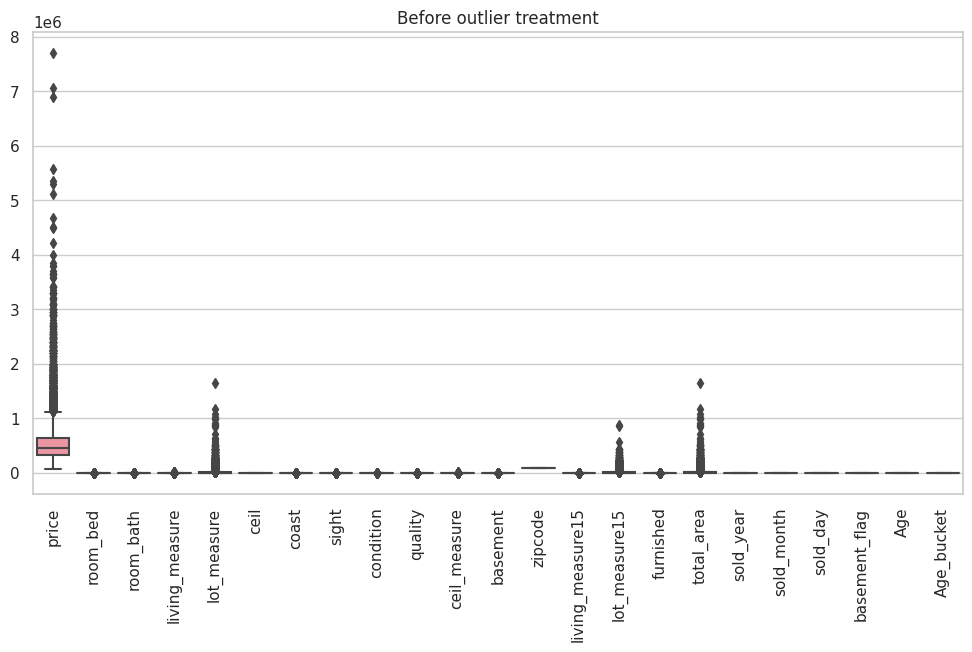

In [ ]:
#Checking for outliers before treatment
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')

# Create a boxplot of all columns
sns.boxplot(data=processing_data)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.title('Before outlier treatment')
# Show the plot
plt.show()

In [ ]:
#Calculating the quantile range to exclude outliers
outliers=processing_data.quantile(0.97)



In [ ]:
#Removing outliers as they are in the price, lot_measure, lot_measure15 and room_bed column
processing_data=processing_data[processing_data['price']<outliers['price']]
processing_data=processing_data[processing_data['lot_measure']<outliers['lot_measure']]
processing_data=processing_data[processing_data['lot_measure15']<outliers['lot_measure15']]

processing_data=processing_data[processing_data['room_bed']<15]


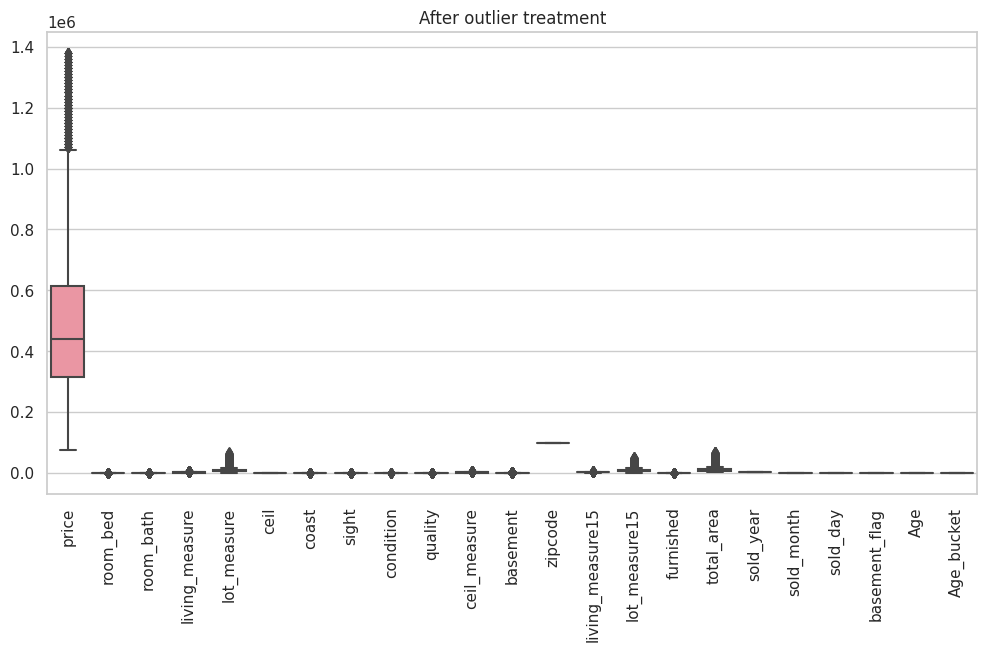

In [ ]:
#Checking for outliers after treatment
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')

# Create a boxplot of all columns
sns.boxplot(data=processing_data)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.title('After outlier treatment')

# Show the plot
plt.show()

The dataset is out of outliers now

In [ ]:
processed_data = processing_data

# **Data Visualization**

# Univariate Analysis

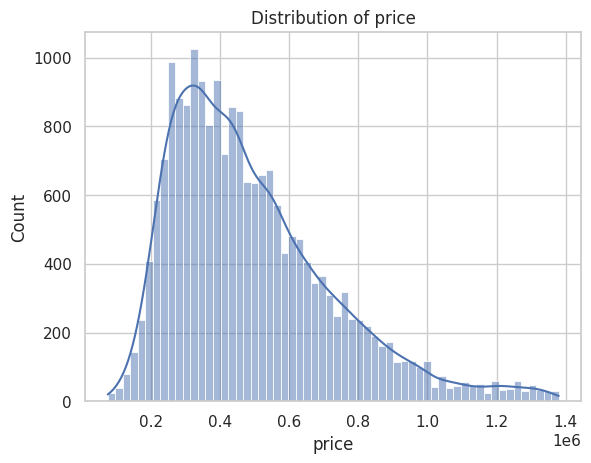

In [ ]:
#target variable analysis of it's distribution
sns.histplot(data=processed_data, x = 'price', kde=True)
plt.title('Distribution of price')
plt.show()

It's right skewed(positive skewness)

Univariate analysis of continuous variables

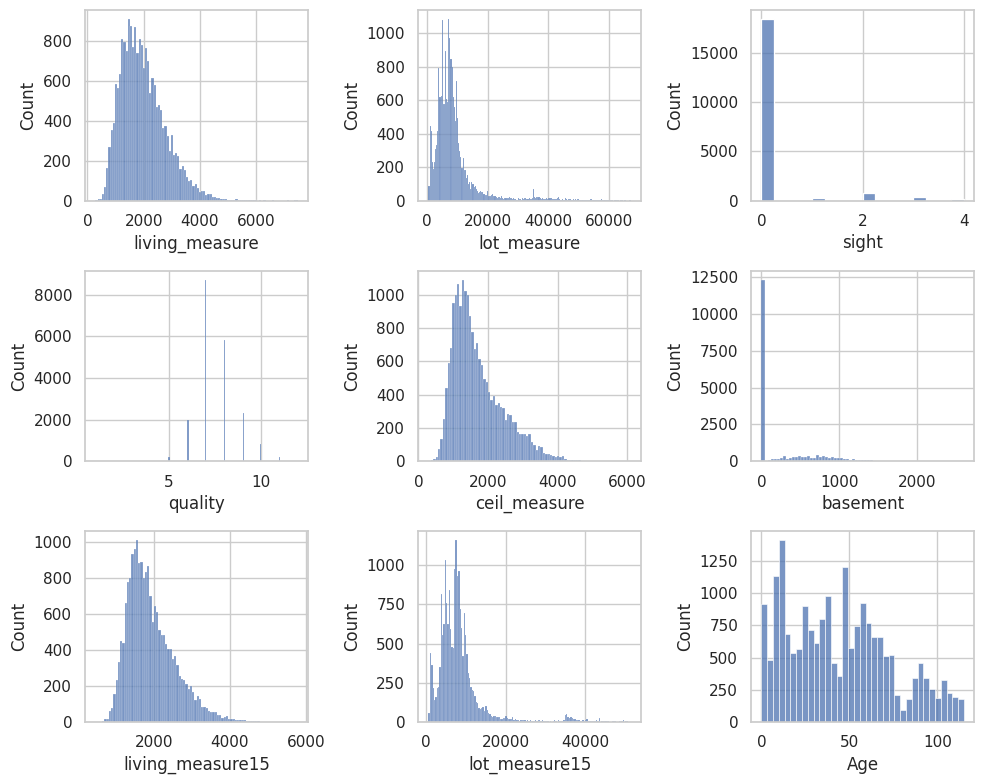

In [ ]:
#for numerical variables
fig, axes = plt.subplots(3, 3, dpi=100, figsize=(10, 8))
# plt.figure(dpi=)

sns.histplot(ax=axes[0,0] , data=processed_data, x="living_measure")
sns.histplot(ax=axes[0,1] , data=processed_data, x="lot_measure")
sns.histplot(ax=axes[0,2] , data=processed_data, x="sight")
sns.histplot(ax=axes[1,0] , data=processed_data, x="quality")
sns.histplot(ax=axes[1,1] , data=processed_data, x="ceil_measure")
sns.histplot(ax=axes[1,2] , data=processed_data, x="basement")
sns.histplot(ax=axes[2,0] , data=processed_data, x="living_measure15")
sns.histplot(ax=axes[2,1] , data=processed_data, x="lot_measure15")
sns.histplot(ax=axes[2,2] , data=processed_data, x="Age")

fig.tight_layout()
plt.show()

<Axes: xlabel='living_measure', ylabel='Count'>

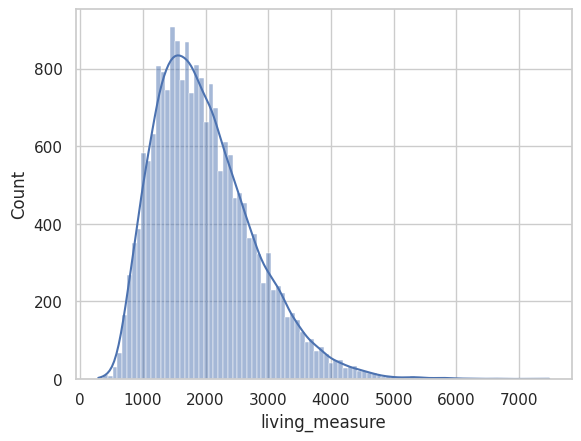

In [ ]:
#Before log transformation the distribution of living_measure is slightly right skewed
sns.histplot(data=processed_data, x='living_measure', kde=True)

Normally distributed living_measure


<Axes: xlabel='living_measure', ylabel='Count'>

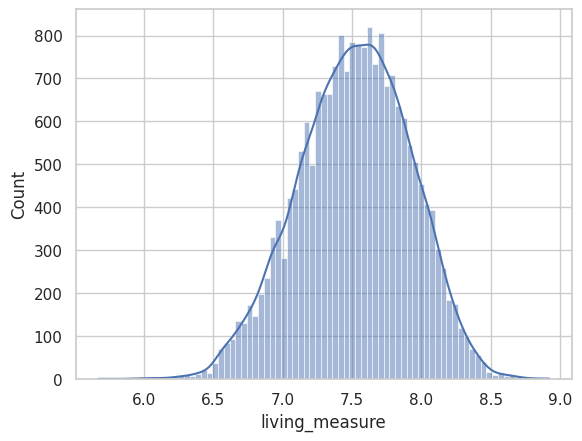

In [ ]:
#After log transformation
processed_data['living_measure'] = np.log1p(processed_data['living_measure'])
print('Normally distributed living_measure')
sns.histplot(data=processed_data, x='living_measure', kde=True)


<Axes: xlabel='ceil_measure', ylabel='Count'>

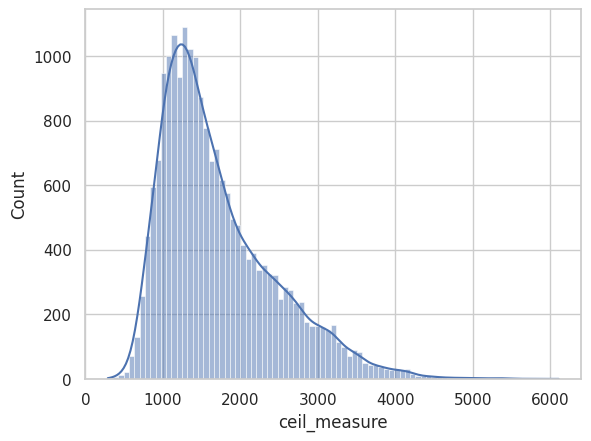

In [ ]:
#Before log transformation the distribution of ceil_measure is slightly right skewed
sns.histplot(data=processed_data, x='ceil_measure', kde=True)

Normally distributed ceil_measure


<Axes: xlabel='ceil_measure', ylabel='Count'>

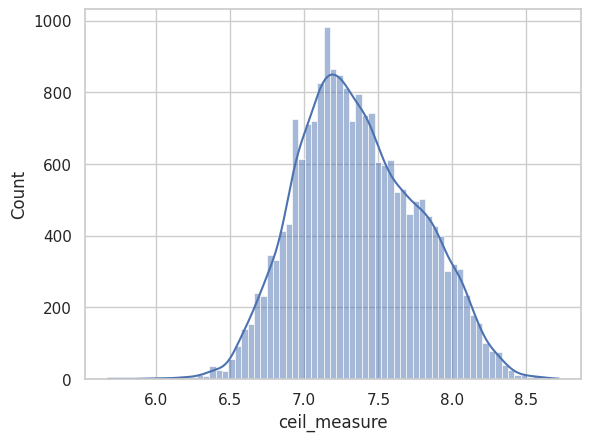

In [ ]:
#After log transformation
processed_data['ceil_measure'] = np.log1p(processed_data['ceil_measure'])
print('Normally distributed ceil_measure')
sns.histplot(data=processed_data, x='ceil_measure', kde=True)


<Axes: xlabel='living_measure15', ylabel='Count'>

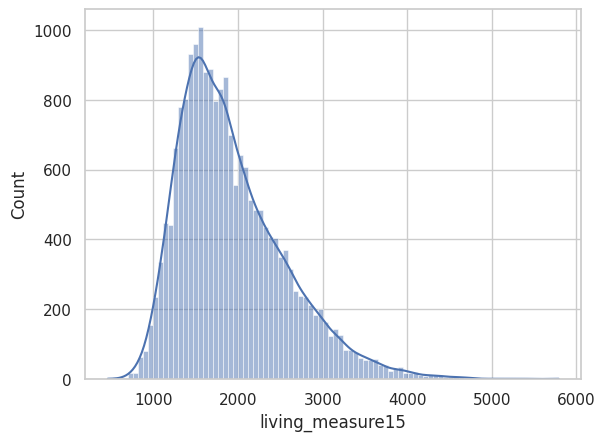

In [ ]:
#Before log transformation the distribution of living_measure15 is slightly right skewed
sns.histplot(data=processed_data, x='living_measure15', kde=True)

Normally distributed living_measure15


<Axes: xlabel='living_measure15', ylabel='Count'>

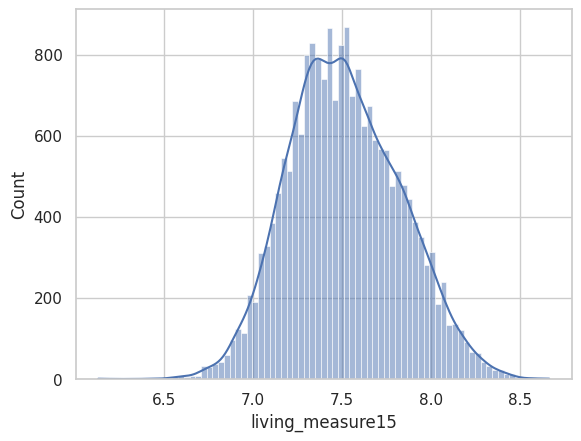

In [ ]:
#After log transformation
processed_data['living_measure15'] = np.log1p(processed_data['living_measure15'])
print('Normally distributed living_measure15')
sns.histplot(data=processed_data, x='living_measure15', kde=True)


Univariate analysis of categorical variables

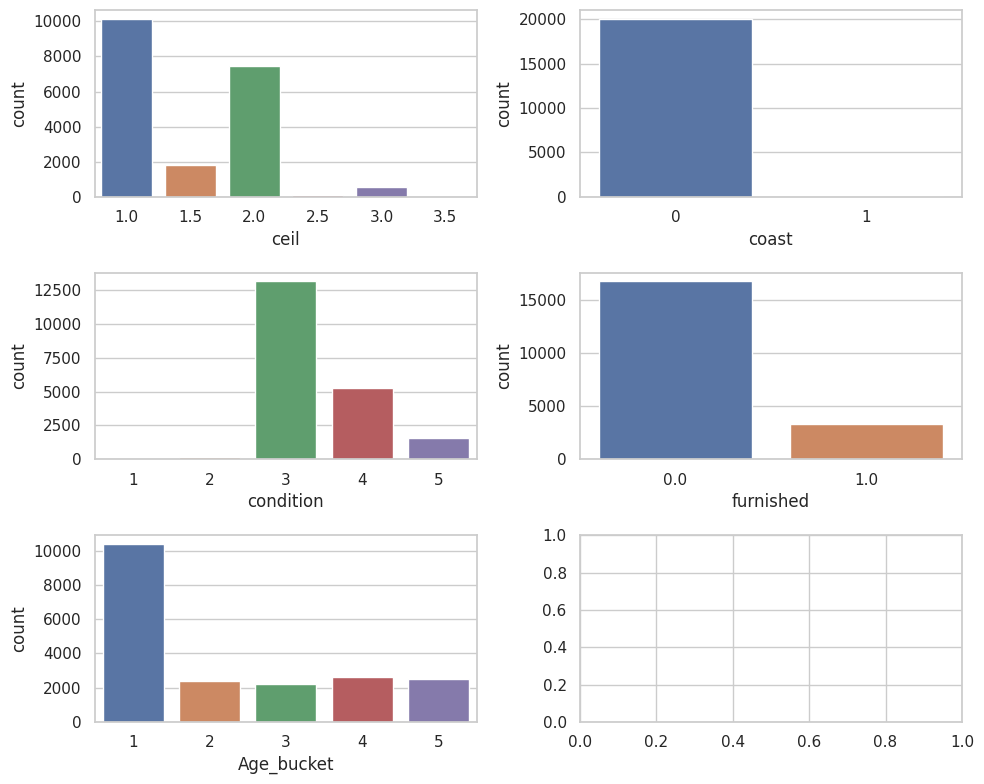

In [ ]:
#for categorical variables
fig, axes = plt.subplots(3, 2, dpi=100, figsize=(10, 8))
# plt.figure(dpi=)

sns.countplot(ax=axes[0,0] , data=processed_data, x="ceil")
sns.countplot(ax=axes[0,1] , data=processed_data, x="coast")
sns.countplot(ax=axes[1,0] , data=processed_data, x="condition")
sns.countplot(ax=axes[1,1] , data=processed_data, x="furnished")
sns.countplot(ax=axes[2,0] , data=processed_data, x="Age_bucket")

fig.tight_layout()
plt.show()

Insights from the analysis:
1. Most of the houses are of one ceiling
2. Most of the houses are not from a coastal region
3. Most of the houses has condition of 3
4. Majority of the houses are not furnished
5. Majority of the houses have built 40 years ago

## Bivariate analysis

Bivariate analysis of numerical features

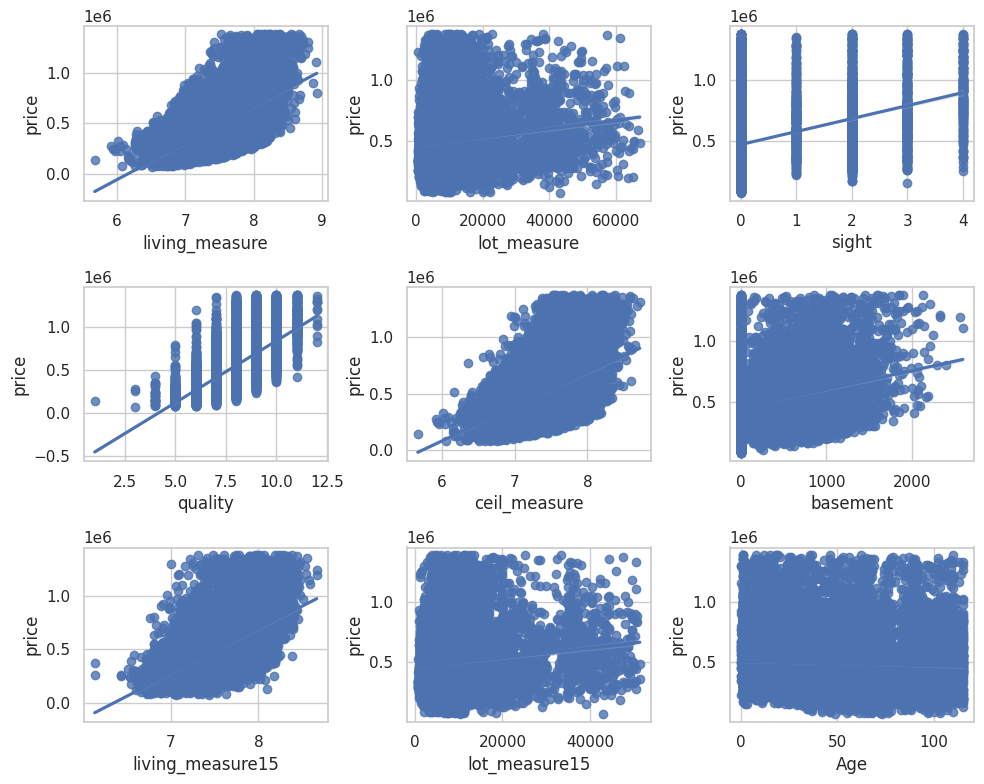

In [ ]:
#Bivariate analysis of numerical variables vs Price

fig, axes = plt.subplots(3, 3, dpi=100, figsize=(10, 8))
# plt.figure(dpi=)

sns.regplot(ax=axes[0,0] , data=processed_data, x="living_measure", y="price")
sns.regplot(ax=axes[0,1] , data=processed_data, x="lot_measure", y="price")
sns.regplot(ax=axes[0,2] , data=processed_data, x="sight", y="price")
sns.regplot(ax=axes[1,0] , data=processed_data, x="quality", y="price")
sns.regplot(ax=axes[1,1] , data=processed_data, x="ceil_measure", y="price")
sns.regplot(ax=axes[1,2] , data=processed_data, x="basement", y="price")
sns.regplot(ax=axes[2,0] , data=processed_data, x="living_measure15", y="price")
sns.regplot(ax=axes[2,1] , data=processed_data, x="lot_measure15", y="price")
sns.regplot(ax=axes[2,2] , data=processed_data, x="Age", y="price")

fig.tight_layout()
plt.show()

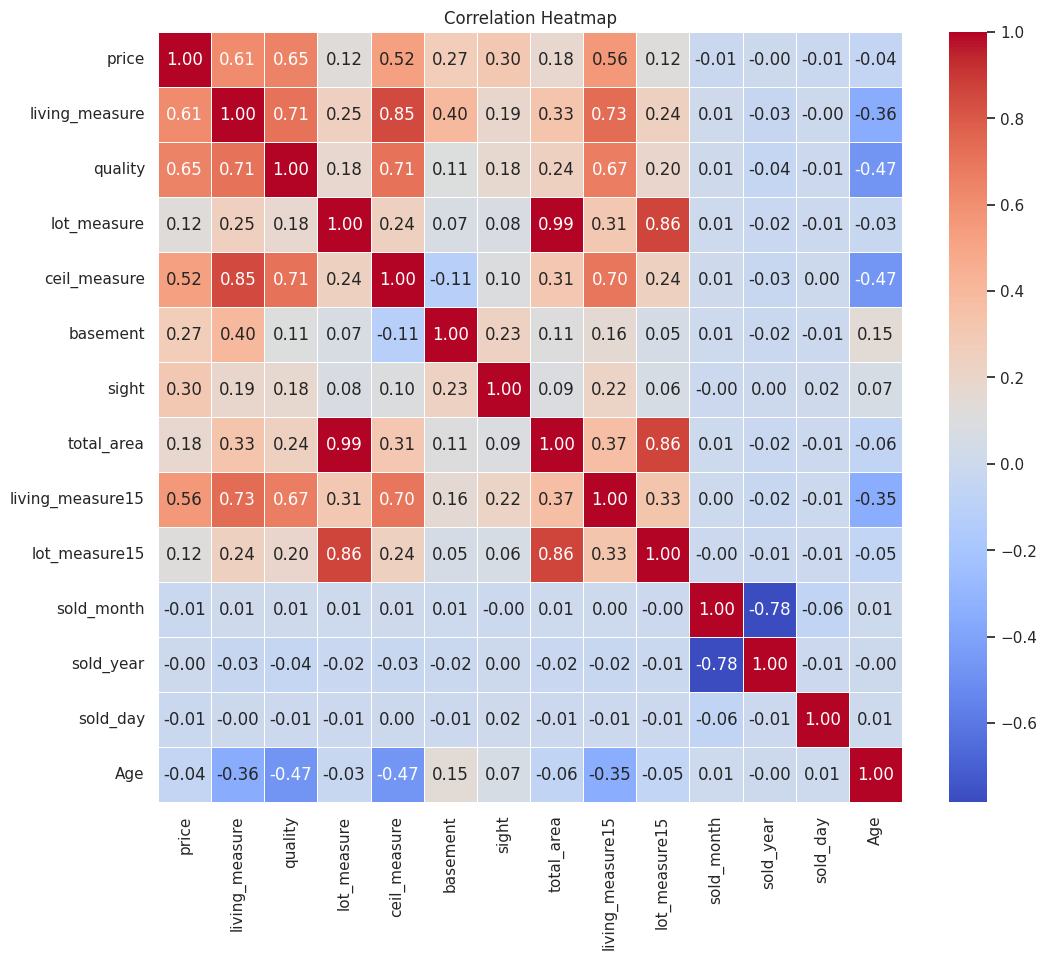

In [ ]:
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed, 'lat
heatmap_features = ['price', 'living_measure', 'quality', 'lot_measure', 'ceil_measure', 'basement', 'sight', 'total_area', 'living_measure15', 'lot_measure15', 'sold_month', 'sold_year', 'sold_day', 'Age']
sns.heatmap(processed_data[heatmap_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
processed_data.corr()['price']

price               1.00
room_bed            0.31
room_bath           0.43
living_measure      0.61
lot_measure         0.12
sight               0.30
quality             0.65
ceil_measure        0.52
basement            0.27
living_measure15    0.56
lot_measure15       0.12
total_area          0.18
sold_year          -0.00
sold_month         -0.01
sold_day           -0.01
basement_flag       0.19
Age                -0.04
Name: price, dtype: float64

Insights from the heat map of correlations:

living_measure, quality, room_bed, room_bath, lat, living_measure15, ceil_measure all these columns have pretty good correlations in terms of price

### Bivariate analysis for categorical variables

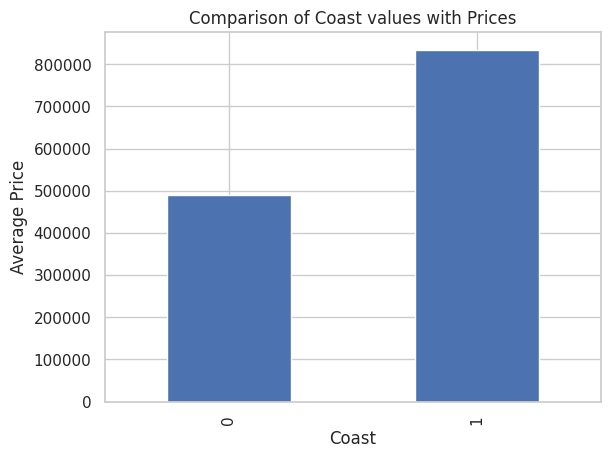

In [ ]:
#Bivariate analysis of coast vs price


# Group the data by 'coast' column and calculate the average price
grouped_data_coast = processed_data.groupby('coast')['price'].mean()

# Create the chart
fig, ax = plt.subplots()
grouped_data_coast.plot(kind='bar', ax=ax)
# ax.set_xticklabels(['Not a coastal region', 'Coastal region'])
ax.set_ylabel('Average Price')
ax.set_xlabel('Coast')
ax.set_title('Comparison of Coast values with Prices')
plt.show()


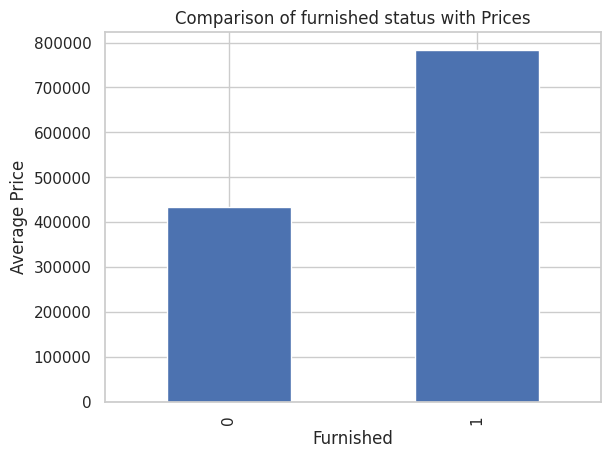

In [ ]:
#Bivariate analysis of coast vs price


# Group the data by 'furnished' column and calculate the average price
grouped_data_furnished = processed_data.groupby('furnished')['price'].mean()

# Create the chart
fig, ax = plt.subplots()
grouped_data_furnished.plot(kind='bar', ax=ax)
ax.set_ylabel('Average Price')
ax.set_xticklabels(['0', '1'])

ax.set_xlabel('Furnished')
ax.set_title('Comparison of furnished status with Prices')
plt.show()


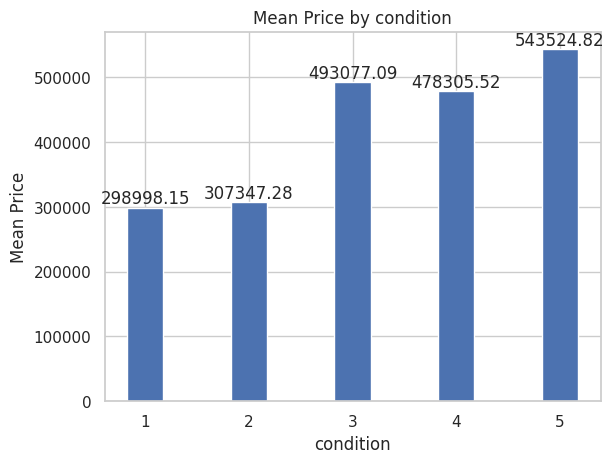

In [ ]:
#Bivariate analysis of condition vs price


# Calculate the mean price for each condition
mean_price_by_condition = processed_data.groupby('condition')['price'].mean()

# # Create a grouped bar plot
conditions = mean_price_by_condition.index
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(conditions, mean_price_by_condition, width)

ax.set_xlabel('condition')
ax.set_ylabel('Mean Price')
ax.set_title('Mean Price by condition')
# ax.set_xticks(conditions)
# ax.set_xticklabels(conditions)

ax.bar_label(rects, fmt='%.2f', label_type='edge')

plt.show()

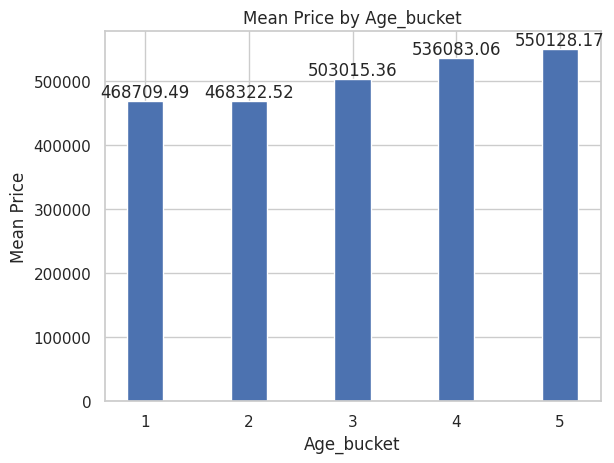

In [ ]:
#Bivariate analysis of Age_bucket vs price

# Calculate the mean price for each condition
mean_price_by_age_bucket = processed_data.groupby('Age_bucket')['price'].mean()

# # Create a grouped bar plot
conditions = mean_price_by_age_bucket.index
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(conditions, mean_price_by_age_bucket, width)

ax.set_xlabel('Age_bucket')
ax.set_ylabel('Mean Price')
ax.set_title('Mean Price by Age_bucket')

ax.bar_label(rects, fmt='%.2f', label_type='edge')

plt.show()

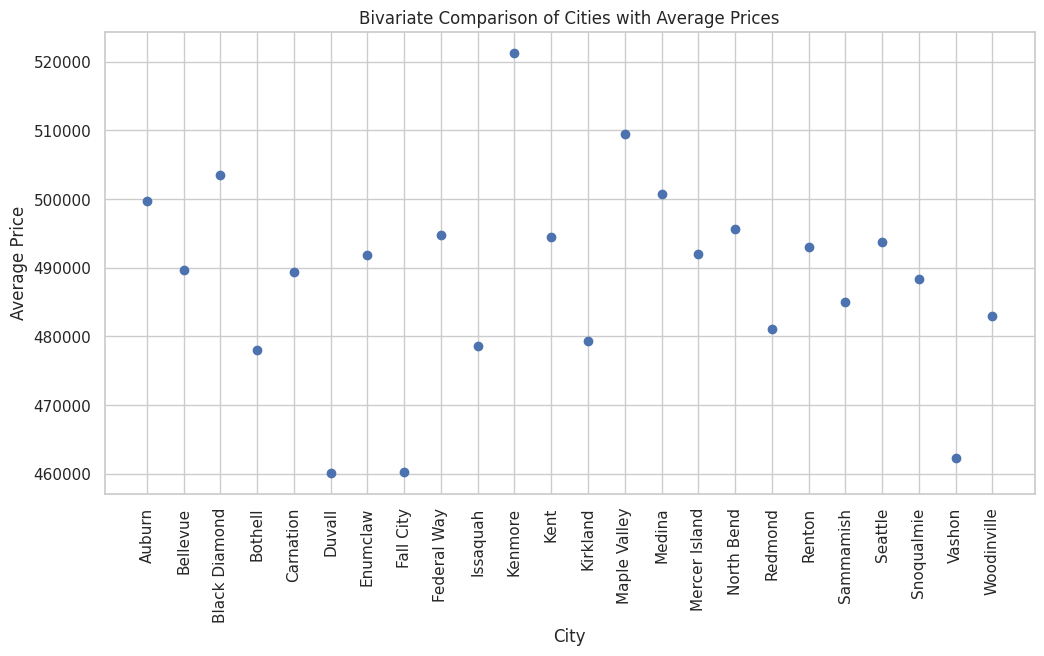

In [ ]:
#Bivariate analysis of city vs price


# Group the data by 'city' and calculate the average price
grouped_data_city = processed_data.groupby('city')['price'].mean()

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(grouped_data_city.index, grouped_data_city.values)
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Bivariate Comparison of Cities with Average Prices')
plt.show()


# **Future tuning and encoding**

Label encoding

In [ ]:
#label encoding
label_encoder = LabelEncoder()
label_Features = ['coast', 'condition', 'sold_date', 'Age_bucket', 'furnished', 'ceil']

for i in label_Features:
  processed_data[i] = label_encoder.fit_transform(processed_data[i])
processed_data[label_Features]

,coast,condition,sold_date,Age_bucket,furnished,ceil
0,0,2,323,0,0,0
1,0,3,203,0,0,0
2,1,2,243,0,0,2
3,0,2,122,4,0,2
4,0,2,213,0,0,0
...,...,...,...,...,...,...
21608,0,2,114,3,1,2
21609,0,2,252,0,0,0
21610,0,2,57,1,1,2
21611,0,2,62,3,0,2


One hot encoding of city and zipcode column

In [ ]:
X = processed_data.drop('price', axis=1)
X = pd.get_dummies(X, columns = ['zipcode', 'city'])

In [ ]:
y = processed_data['price']

## Scaling of features

In [ ]:
scaler = MinMaxScaler()

In [ ]:
#Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


In [ ]:
#scaling the features
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

# **Model building**

### Linear Regression

In [ ]:
#Creating the object for the Linear Regression model
lr=LinearRegression()

In [ ]:
#Fitting the train data into the model
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
#predicting with the x_test
lr_pred_test = lr.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE for test data
lr_r2_score_test = r2_score(y_test, lr_pred_test)
lr_adj_r2_score_test = adjusted_r2_score(y_test, lr_pred_test, 118)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred_test))

In [ ]:
#Printing the r2_score and RMSE for test data
print(f"Linear Regression R squared test score: {lr_r2_score_test}")
print(f"Linear Regression Adjusted R squared score: {lr_adj_r2_score_test}")
print(f"Linear Regression RMSE: {lr_rmse}")


Linear Regression R squared test score: 0.8411675865449643
Linear Regression Adjusted R squared score: 0.8363692699070497
Linear Regression RMSE: 95062.28416176811


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(lr, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (Linear Regression): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores (Linear Regression):  [0.83697767 0.83238328 0.83773708 0.82842018 0.83698534]
Average CV Score:  0.8345007074465876
Number of CV Scores used in Average:  5


### Decision Tree

In [ ]:
#Creating an object of the DecisionTreeRegressor
DTR = DecisionTreeRegressor(max_depth=4)

In [ ]:
#Fitting the train data into the model
DTR.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [ ]:
#predicting with the x_test
dtr_pred = DTR.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE
dtr_r2_score = r2_score(y_test, dtr_pred)
dtr_adj_r2_score = adjusted_r2_score(y_test, dtr_pred, 118)
dtr_rmse = np.sqrt(mean_squared_error(y_test, dtr_pred))

In [ ]:
#Printing the r2_score and RMSE
print(f"Decision Tree Regression R squared test score: {dtr_r2_score}")
print(f"Decision Tree Regression Adjusted R squared test score: {dtr_adj_r2_score}")
print(f"Decision Tree Regression RMSE: {dtr_rmse}")


Decision Tree Regression R squared test score: 0.5364757122021069
Decision Tree Regression Adjusted R squared test score: 0.5224726743218837
Decision Tree Regression RMSE: 162395.84952757112


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(DTR, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (Decision Tree): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores (Decision Tree):  [0.54139706 0.5409883  0.51297269 0.54364575 0.5284329 ]
Average CV Score:  0.5334873402563608
Number of CV Scores used in Average:  5


## Ridge Regression

In [ ]:
#Creating an object of the Ridge Regressor
RGR = Ridge()

In [ ]:
#Fitting the train data into the model
RGR.fit(x_train, y_train)

Ridge()

In [ ]:
#predicting with the x_test
rgr_pred = RGR.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE
rgr_r2_score = r2_score(y_test, rgr_pred)
rgr_adj_r2_score = adjusted_r2_score(y_test, rgr_pred, 118)
rgr_rmse = np.sqrt(mean_squared_error(y_test, rgr_pred))

In [ ]:
#Printing the r2_score and RMSE
print(f"Ridge Regression R squared test score: {rgr_r2_score}")
print(f"Ridge Regression Adjusted R squared test score: {rgr_adj_r2_score}")
print(f"Ridge Regression RMSE: {rgr_rmse}")


Ridge Regression R squared test score: 0.8406459867031355
Ridge Regression Adjusted R squared test score: 0.8358319125687192
Ridge Regression RMSE: 95218.2467565926


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(RGR, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (Ridge Regression): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores (Ridge Regression):  [0.83669759 0.83175716 0.83691952 0.8314534  0.83653077]
Average CV Score:  0.8346716892983677
Number of CV Scores used in Average:  5


## XGB Regressor

In [ ]:
#Creating an object of the XGB Regressor
XGB = XGBRegressor()

In [ ]:
#Fitting the train data into the model
XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
#predicting with the x_test
xgb_pred = XGB.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE
xgb_r2_score = r2_score(y_test, xgb_pred)
xgb_adj_r2_score = adjusted_r2_score(y_test, xgb_pred, 118)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

In [ ]:
#Printing the r2_score and RMSE
print(f"XGB Regression R squared test score: {xgb_r2_score}")
print(f"XGB Regression Adjusted R squared test score: {xgb_adj_r2_score}")
print(f"XGB Regression RMSE: {xgb_rmse}")


XGB Regression R squared test score: 0.8565365748540176
XGB Regression Adjusted R squared test score: 0.8522025543298942
XGB Regression RMSE: 90346.07201627697


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(XGB, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (XGB Regressor): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores (XGB Regressor):  [0.85475058 0.85232702 0.84529409 0.84300718 0.84756365]
Average CV Score:  0.8485885057129018
Number of CV Scores used in Average:  5


## Light GBM Regressor

In [ ]:
#Creating an object of the LGBM Regressor
LGBM =  lgb.LGBMRegressor()

In [ ]:
#Fitting the train data into the model
LGBM.fit(x_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data points in the train set: 16099, number of used features: 115
[LightGBM] [Info] Start training from score 491602.196099


LGBMRegressor()

In [ ]:
#predicting with the x_test
lgbm_pred = LGBM.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE
lgbm_r2_score = r2_score(y_test, lgbm_pred)
lgbm_adj_r2_score = adjusted_r2_score(y_test, lgbm_pred, 118)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))

In [ ]:
#Printing the r2_score and RMSE
print(f"LGBM Regression R squared test score: {lgbm_r2_score}")
print(f"LGBM Regression Adjusted R squared test score: {lgbm_adj_r2_score}")
print(f"LGBM Regression RMSE: {lgbm_rmse}")


LGBM Regression R squared test score: 0.8589970907813169
LGBM Regression Adjusted R squared test score: 0.8547374022795748
LGBM Regression RMSE: 89567.96651831748


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(LGBM, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (LGBM Regressor): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 12879, number of used features: 114
[LightGBM] [Info] Start training from score 491145.587002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 12879, number of used features: 114
[LightGBM] [Info] Start training from score 491842.687553
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

## Cat Boost Regressor

In [ ]:

#Creating an object of the Cat Boost Regressor
CB = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')

In [ ]:
#Fitting the train data into the model
CB.fit(x_train, y_train)

0:	learn: 223272.3682887	total: 54.9ms	remaining: 54.9s
1:	learn: 212935.2155143	total: 61.2ms	remaining: 30.5s
2:	learn: 203905.5851482	total: 66.8ms	remaining: 22.2s
3:	learn: 195878.2717487	total: 84.9ms	remaining: 21.1s
4:	learn: 188859.0243907	total: 90.6ms	remaining: 18s
5:	learn: 182212.2288258	total: 102ms	remaining: 16.9s
6:	learn: 177054.0138012	total: 108ms	remaining: 15.3s
7:	learn: 172543.2330466	total: 113ms	remaining: 14s
8:	learn: 168111.2219735	total: 119ms	remaining: 13.1s
9:	learn: 163881.6227238	total: 124ms	remaining: 12.3s
10:	learn: 160535.1706639	total: 129ms	remaining: 11.6s
11:	learn: 157468.4252986	total: 135ms	remaining: 11.1s
12:	learn: 154442.5576459	total: 141ms	remaining: 10.7s
13:	learn: 151700.9802160	total: 147ms	remaining: 10.3s
14:	learn: 149463.1692797	total: 152ms	remaining: 10s
15:	learn: 147300.9891598	total: 158ms	remaining: 9.7s
16:	learn: 145340.8355596	total: 164ms	remaining: 9.46s
17:	learn: 143562.8304547	total: 169ms	remaining: 9.23s
18:	

In [ ]:
#predicting with the x_test
cb_pred = CB.predict(x_test)

In [ ]:
#Calculating the r2_score and RMSE
cb_r2_score = r2_score(y_test, cb_pred)
cb_adj_r2_score = adjusted_r2_score(y_test, cb_pred, 118)
cb_rmse = np.sqrt(mean_squared_error(y_test, cb_pred))

In [ ]:
#Printing the r2_score and RMSE
print(f"Cat Boost Regression R2 test score: {cb_r2_score}")
print(f"Cat Boost Regression Adjusted R squared test score: {cb_adj_r2_score}")
print(f"Cat Boost RMSE: {cb_rmse}")


Cat Boost Regression R2 test score: 0.8790401187069279
Cat Boost Regression R2 test score: 0.8753859287446691
Cat Boost RMSE: 82958.20639651395


In [ ]:
#Cross validating
k_folds = KFold(n_splits = 5)
scores = cross_val_score(CB, x_train, y_train, cv = k_folds)

print("Cross Validation Scores (Cat Boost Regressor): ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Streaming output truncated to the last 5000 lines.
3:	learn: 195318.7827914	total: 23.8ms	remaining: 5.93s
4:	learn: 188002.9140801	total: 29.4ms	remaining: 5.84s
5:	learn: 181660.1654709	total: 34.6ms	remaining: 5.74s
6:	learn: 176482.5280419	total: 39.7ms	remaining: 5.63s
7:	learn: 171526.3114992	total: 44.9ms	remaining: 5.57s
8:	learn: 167608.2748269	total: 54.5ms	remaining: 6s
9:	learn: 163915.4073032	total: 67ms	remaining: 6.63s
10:	learn: 160184.8124952	total: 81.2ms	remaining: 7.3s
11:	learn: 157053.6146848	total: 89.2ms	remaining: 7.34s
12:	learn: 154086.1069025	total: 94.5ms	remaining: 7.17s
13:	learn: 151357.0208548	total: 99.7ms	remaining: 7.02s
14:	learn: 149390.4111348	total: 105ms	remaining: 6.89s
15:	learn: 147334.2291695	total: 110ms	remaining: 6.77s
16:	learn: 145315.2529095	total: 116ms	remaining: 6.68s
17:	learn: 143335.0211802	total: 121ms	remaining: 6.58s
18:	learn: 141773.3365759	total: 125ms	remaining: 6.48s
19:	learn: 140411.1909708	total: 131ms	remaining: 6.4s


## Model comparisons

In [ ]:

def algo_test(x,y):

    L = LinearRegression()
    R = Ridge()
    XGBC= XGBRegressor()
    LGBM = lgb.LGBMRegressor()
    CB = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')
    DTR = DecisionTreeRegressor(max_depth=4)


    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    algos = [L,R,XGBC, LGBM, CB, DTR]
    algo_names = ['Linear','Ridge','XGradientBooting', 'Light GBM', 'Cat Boost', 'Decision Tree']
    train_r_squared = []
    test_r_squared = []
    train_rmse = []
    test_rmse = []
    train_mae = []
    test_mae = []

    result = pd.DataFrame(columns = ['Train_R_Squared','Test_R_Squared','Train_RMSE','Test_RMSE','Train_MAE', 'Test_MAE'],index = algo_names)

    for algo in algos:
        algo.fit(x_train,y_train)
        train_r_squared.append(r2_score(y_train,algo.predict(x_train)))
        test_r_squared.append(r2_score(y_test,algo.predict(x_test)))
        train_rmse.append(mean_squared_error(y_train, algo.predict(x_train))**.5)
        test_rmse.append(mean_squared_error(y_test, algo.predict(x_test))**.5)
        train_mae.append(mean_absolute_error(y_train, algo.predict(x_train)))
        test_mae.append(mean_absolute_error(y_test, algo.predict(x_test)))

    result.Train_R_Squared = train_r_squared
    result.Test_R_Squared = test_r_squared
    result.Train_RMSE = train_rmse
    result.Test_RMSE = test_rmse
    result.Train_MAE= train_mae
    result.Test_MAE= test_mae

    return result.sort_values('Test_R_Squared', ascending=False)


In [ ]:
algo_test(X,y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2392
[LightGBM] [Info] Number of data points in the train set: 16099, number of used features: 115
[LightGBM] [Info] Start training from score 491602.196099
0:	learn: 223272.3682887	total: 34.1ms	remaining: 34.1s
1:	learn: 212935.2155143	total: 61.3ms	remaining: 30.6s
2:	learn: 203905.5851482	total: 76.6ms	remaining: 25.5s
3:	learn: 195878.2717487	total: 111ms	remaining: 27.6s
4:	learn: 188859.0243907	total: 124ms	remaining: 24.7s
5:	learn: 182212.2288258	total: 141ms	remaining: 23.3s
6:	learn: 177054.0138012	total: 159ms	remaining: 22.5s
7:	learn: 172543.2330466	total: 170ms	remaining: 21.1s
8:	learn: 168111.2219735	total: 184ms	remaining: 20.3s
9:	lear

,Train_R_Squared,Test_R_Squared,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
Cat Boost,0.94,0.88,58679.56,82961.74,43073.81,57280.90
Light GBM,0.89,0.86,78791.97,89868.24,56060.92,63499.33
XGradientBooting,0.94,0.86,59195.87,90340.01,42868.68,62603.28
Linear,0.84,0.84,94689.95,95062.39,67439.21,68239.05
Ridge,0.84,0.84,94701.71,95091.43,67420.34,68225.22
Decision Tree,0.55,0.54,158208.94,162395.85,121244.09,124809.37


## Conclusion

After evaluating all the models performance Cat Boost model is considered the best model with the following values:

In [ ]:
#Performance of Cat Boost model
train_r_squared = []
test_r_squared = []
train_rmse = []
test_rmse = []
train_mae = []
test_mae = []
result = pd.DataFrame(columns = ['Train_R_Squared','Test_R_Squared','Train_RMSE','Test_RMSE','Train_MAE', 'Test_MAE'])
train_r_squared.append(r2_score(y_train,CB.predict(x_train)))
test_r_squared.append(r2_score(y_test,CB.predict(x_test)))
train_rmse.append(mean_squared_error(y_train, CB.predict(x_train))**.5)
test_rmse.append(mean_squared_error(y_test, CB.predict(x_test))**.5)
train_mae.append(mean_absolute_error(y_train, CB.predict(x_train)))
test_mae.append(mean_absolute_error(y_test, CB.predict(x_test)))
result.Train_R_Squared = train_r_squared
result.Test_R_Squared = test_r_squared
result.Train_RMSE = train_rmse
result.Test_RMSE = test_rmse
result.Train_MAE= train_mae
result.Test_MAE= test_mae

print('Cat Boost Model Performance')
result

Cat Boost Model Performance


,Train_R_Squared,Test_R_Squared,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
0,0.94,0.88,58679.56,82958.21,43073.81,57274.22


## **Model Interpretation and feature importance**

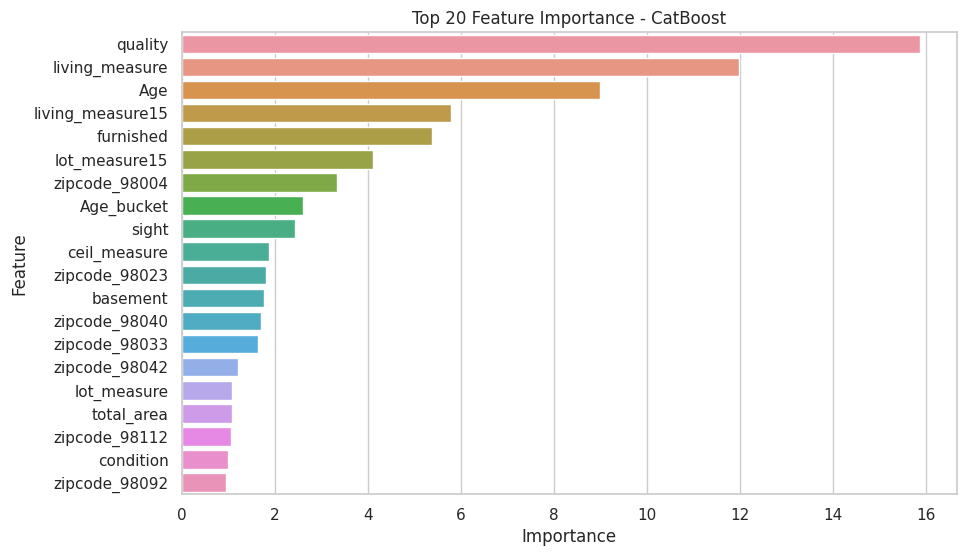

In [ ]:


# Feature Importance
def plot_feature_importance(model, feature_names, top_n=10):
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the top N features
    top_features = feature_importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Feature Importance - CatBoost')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


# Print the top 20 features based on importance
plot_feature_importance(CB, X_train.columns, top_n=20)




Insights from the graph:

We are able to clearly see the features that plays an important role in predicting the house price in the cat boost model.  Some features include latitude, living_measure, quality, longitude, living_measure15, etc

## **Ensemble modelling**

In [ ]:
# Create the stacking ensemble as Catboost, Light gbm, linear regression as base model and Ridge regression
# as meta model
base_models = [('catboost', CB), ('lgbm', LGBM), ('linear_reg', lr)]
stacking_model = StackingRegressor(estimators=base_models, final_estimator=RGR)

# Fit the base models
for name, model in base_models:
    model.fit(x_train, y_train)

# Fit the stacking model (meta-model)
stacking_model.fit(x_train, y_train)
stacking_model_pred = stacking_model.predict(x_test)
print(f"R squared score of ensemble model: {r2_score(y_test, stacking_model_pred)}")
print(f"Adjusted R squared score of ensemble model: {adjusted_r2_score(y_test, stacking_model_pred,118)}")
print(f"RMSE of ensemble model: {np.sqrt(mean_squared_error(y_test,stacking_model_pred ))}")

Streaming output truncated to the last 5000 lines.
33:	learn: 126256.3828665	total: 191ms	remaining: 5.44s
34:	learn: 125655.1520460	total: 196ms	remaining: 5.41s
35:	learn: 124905.0506617	total: 206ms	remaining: 5.51s
36:	learn: 124175.2410595	total: 215ms	remaining: 5.58s
37:	learn: 123526.2406165	total: 220ms	remaining: 5.58s
38:	learn: 122908.1570752	total: 225ms	remaining: 5.55s
39:	learn: 122242.2048353	total: 230ms	remaining: 5.53s
40:	learn: 121636.3107861	total: 235ms	remaining: 5.5s
41:	learn: 121000.7410088	total: 240ms	remaining: 5.48s
42:	learn: 120434.5677220	total: 245ms	remaining: 5.46s
43:	learn: 119850.7974912	total: 250ms	remaining: 5.43s
44:	learn: 119342.4561917	total: 255ms	remaining: 5.41s
45:	learn: 118942.8415152	total: 260ms	remaining: 5.39s
46:	learn: 118502.5227112	total: 265ms	remaining: 5.37s
47:	learn: 118024.1665057	total: 271ms	remaining: 5.38s
48:	learn: 117559.9745361	total: 276ms	remaining: 5.36s
49:	learn: 117073.3236381	total: 281ms	remaining: 5.34